<a href="https://colab.research.google.com/github/monicasjsu/deep_learning/blob/master/KerasRESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing CIFAR10 Data

In [0]:
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


Displaying the sameple images

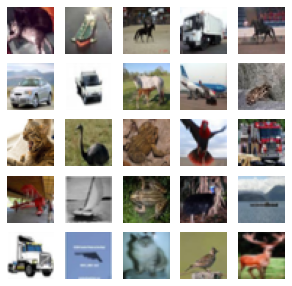

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# from six.moves import cPickle 

rows = 5
x = x_train.astype("uint8")
fig, axes1 = plt.subplots(rows, rows, figsize=(5,5))
for j in range(rows):
    for k in range(rows):
        i = np.random.choice(range(len(x)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x[i:i+1][0])


Adding the Models Constansts

In [0]:
import numpy as np

BATCH_SIZE = 32  
EPOCHS = 20
USE_AUGMENTATION = True
NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = x_train.shape[3]
SUBTRACT_PIXEL_MEAN = True
DEPTH = 8

Learning rate decay schedule

In [0]:
def lr_scheduler(epoch):
    lRate = 1e-3
    if epoch > 120:
        lRate *= 1e-2
    elif epoch > 80:
        lRate *= 1e-1
    print('LearningRate -', lRate)
    return lRate

Defining ResNet Block

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  
  convLayer = Conv2D(num_filters,
                    kernel_size,
                    strides=strides,
                    padding='same',
                    kernel_initializer='he_normal',
                    kernel_regularizer=l2(1e-4))
  x = inputs
  if conv_first:
      x = convLayer(x)
      if batch_normalization:
          x = BatchNormalization()(x)
      if activation is not None:
          x = Activation(activation)(x)
  else:
      if batch_normalization:
          x = BatchNormalization()(x)
      if activation is not None:
          x = Activation(activation)(x)
      x = convLayer(x)
  return x

RESTNet Model

In [0]:


def resnet_model(input_shape, depth, num_classes=10):
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for block in range(3):
        strides = 1
        if block > 0 :
            strides = 2  # downsample
        y = resnet_layer(inputs=x,
                          num_filters=num_filters,
                          strides=strides)
        y = resnet_layer(inputs=y,
                          num_filters=num_filters,
                          activation=None)
        if block > 0:
            x = resnet_layer(inputs=x,
                              num_filters=num_filters,
                              kernel_size=1,
                              strides=strides,
                              activation=None,
                              batch_normalization=False)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)
        num_filters *= 2

    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

Running the Model

In [0]:
from keras.layers import Dense, Conv2D
from keras.layers import BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
# from keras.optimizers import Adam


input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)


model = resnet_model(input_shape=input_shape, depth=DEPTH)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_scheduler(0)),
              metrics=['accuracy'])
model.summary()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
LearningRate - 0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_

Model Learn

In [0]:

lr_schedule = LearningRateScheduler(lr_scheduler)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_schedule]

model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
LearningRate - 0.001
50000/50000 [==============================] - 27s 537us/step - loss: 1.4818 - accuracy: 0.4878 - val_loss: 1.2926 - val_accuracy: 0.5637
Epoch 2/20
LearningRate - 0.001
50000/50000 [==============================] - 23s 465us/step - loss: 1.1181 - accuracy: 0.6271 - val_loss: 1.1081 - val_accuracy: 0.6243
Epoch 3/20
LearningRate - 0.001
50000/50000 [==============================] - 23s 465us/step - loss: 0.9815 - accuracy: 0.6807 - val_loss: 1.0758 - val_accuracy: 0.6422
Epoch 4/20
LearningRate - 0.001
50000/50000 [==============================] - 23s 464us/step - loss: 0.9013 - accuracy: 0.7095 - val_loss: 1.0000 - val_accuracy: 0.6740
Epoch 5/20
LearningRate - 0.001
50000/50000 [==============================] - 23s 463us/step - loss: 0.8369 - accuracy: 0.7323 - val_loss: 0.9458 - val_accuracy: 0.7024
Epoch 6/20
LearningRate - 0.001
50000/50000 [==============================] - 23s 462us/step - loss

Scores

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 138us/step
Test loss: 0.9531432638168335
Test accuracy: 0.7394999861717224
